## Create custom dataset
<https://pytorch.org/tutorials/beginner/basics/data_tutorial.html>

In [15]:
import torchvision.io
from sklearn.preprocessing import LabelEncoder
import librosa
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

class CustomAudioDataset(Dataset):
    def __init__(self, df, recording_dir, transform=None, target_transform=None):
        """
        Parameters
        ----------
        df: pd.DataFrame
            DataFrame of xeno-canto recordings
        recording_dir: str
            filepath to directory with recordings
        transform:
        target_transform:
        """
        
        df['filepath'] = df.apply(lambda x: f"{recording_dir}{x['Latin name']}/{str(x['id'])}.mp3" , axis=1)
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['Latin name'])
        
        self.filepath = df['filepath'].to_numpy()
        self.label = df['label'].to_numpy()
        self.recording_dir = recording_dir
        self.transform = transform
        self.target_transform = target_transform
        self.le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        self.pipeline = MyPipeline(target_sr=32000)

    def __len__(self):
        return self.filepath.size

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.filepath[idx])
        label = self.label[idx]
        
        audio = torch.from_numpy(audio).type(torch.float32)
        label = torch.tensor(label, dtype=torch.int8)
        
        # augmented = pipeline(audio, sr)
        
        if self.transform:
            audio = self.transform(audio)
        if self.target_transform:
            label = self.target_transform(label)       
        
        return audio, label


## Split dataset

In [16]:
RECORDINGS_DIR = '/Users/zosia/Desktop/recordings_30/'

df = filter_recordings_30()

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5)

train_ds = CustomAudioDataset(train_df, recording_dir=RECORDINGS_DIR)
val_ds = CustomAudioDataset(val_df, recording_dir=RECORDINGS_DIR)
test_ds = CustomAudioDataset(test_df, recording_dir=RECORDINGS_DIR)

/Users/zosia/Desktop/Bird-classification-model/birdclassification/preprocessing/filtering.py:43: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv("../data/xeno_canto_recordings.csv")


In [17]:
print(train_ds.__len__())
print(val_ds.__len__())
print(test_ds.__len__())

32968
4121
4121


In [4]:
for i in range(5):
    print(train_ds[i])


(tensor([ 0.0012,  0.0019,  0.0024,  ..., -0.0062, -0.0025,  0.0036]), tensor(18, dtype=torch.int8))
(tensor([-0.0110, -0.0098, -0.0105,  ..., -0.0100, -0.0101,  0.0000]), tensor(0, dtype=torch.int8))
(tensor([ 0.0027,  0.0006, -0.0058,  ...,  0.0012,  0.0018,  0.0015]), tensor(18, dtype=torch.int8))
(tensor([-2.3942e-09,  1.3064e-09, -1.0485e-09,  ...,  1.5433e-11,
        -6.9640e-10, -3.4007e-11]), tensor(27, dtype=torch.int8))
(tensor([0.0146, 0.0190, 0.0160,  ..., 0.0161, 0.0148, 0.0099]), tensor(0, dtype=torch.int8))


## DataLoader

In [5]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [6]:
# for element in train_dataloader:
#     print(element)

## Example of custom transform on audio

Signal shape: torch.Size([99286])
 Sampling rate: 20000


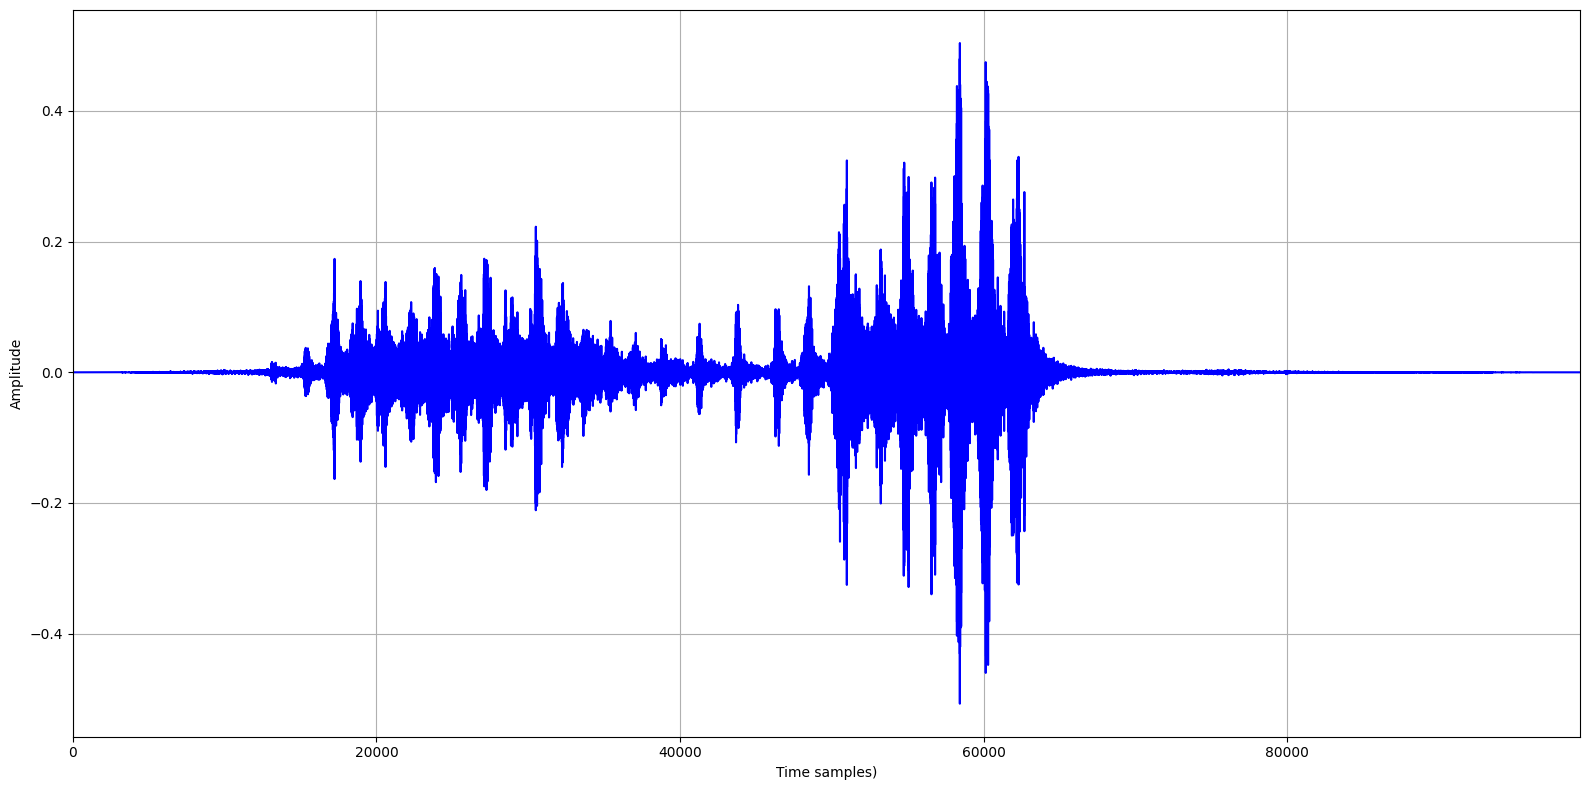

In [7]:
from birdclassification.visualization.plots import plot_waveform
audio, label = train_ds[3]
plot_waveform(audio, 20000)

In [13]:
import random
from torchaudio.transforms import Resample
from birdclassification.preprocessing.augmentations_wrappers import InvertPolarity, AddWhiteNoise, PitchShifting, RandomGain, TimeShift, RandomChunk

class MyPipeline(torch.nn.Module):
    def __init__(self, target_sr):
        super().__init__()
        self.target_sr = target_sr
        self.augmentations = [InvertPolarity(), 
                              AddWhiteNoise(min_factor=0.1, max_factor=0.8), 
                              RandomGain(min_factor=0.5, max_factor=1.5), 
                              TimeShift(min_factor=0.1, max_factor=0.3), 
                              RandomChunk(sr = target_sr, min_factor=0.1 , max_factor=1), 
                              PitchShifting(sr = target_sr, min_semitones=1, max_semitones=10)] 
        
        self.probabilities = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
            
    def forward(self, waveform: torch.Tensor, sr) -> torch.Tensor:
        resample = Resample(sr, self.target_sr)
        resampled = resample(waveform)
        
        n = random.randint(0, len(self.augmentations))
        
        selected = random.choices(list(self.augmentations), weights=self.probabilities, k=n)
        print(selected)
        
        aug = torch.nn.Sequential(*selected)
        augmented = aug(resampled)
        
        return augmented

[AddWhiteNoise(), TimeShift(), PitchShifting()]
Function: 'add_white_noise', execution time: 0.0018649101257324219
Function: 'time_shift', execution time: 0.00014591217041015625
Signal shape: torch.Size([99286])
 Sampling rate: 20000


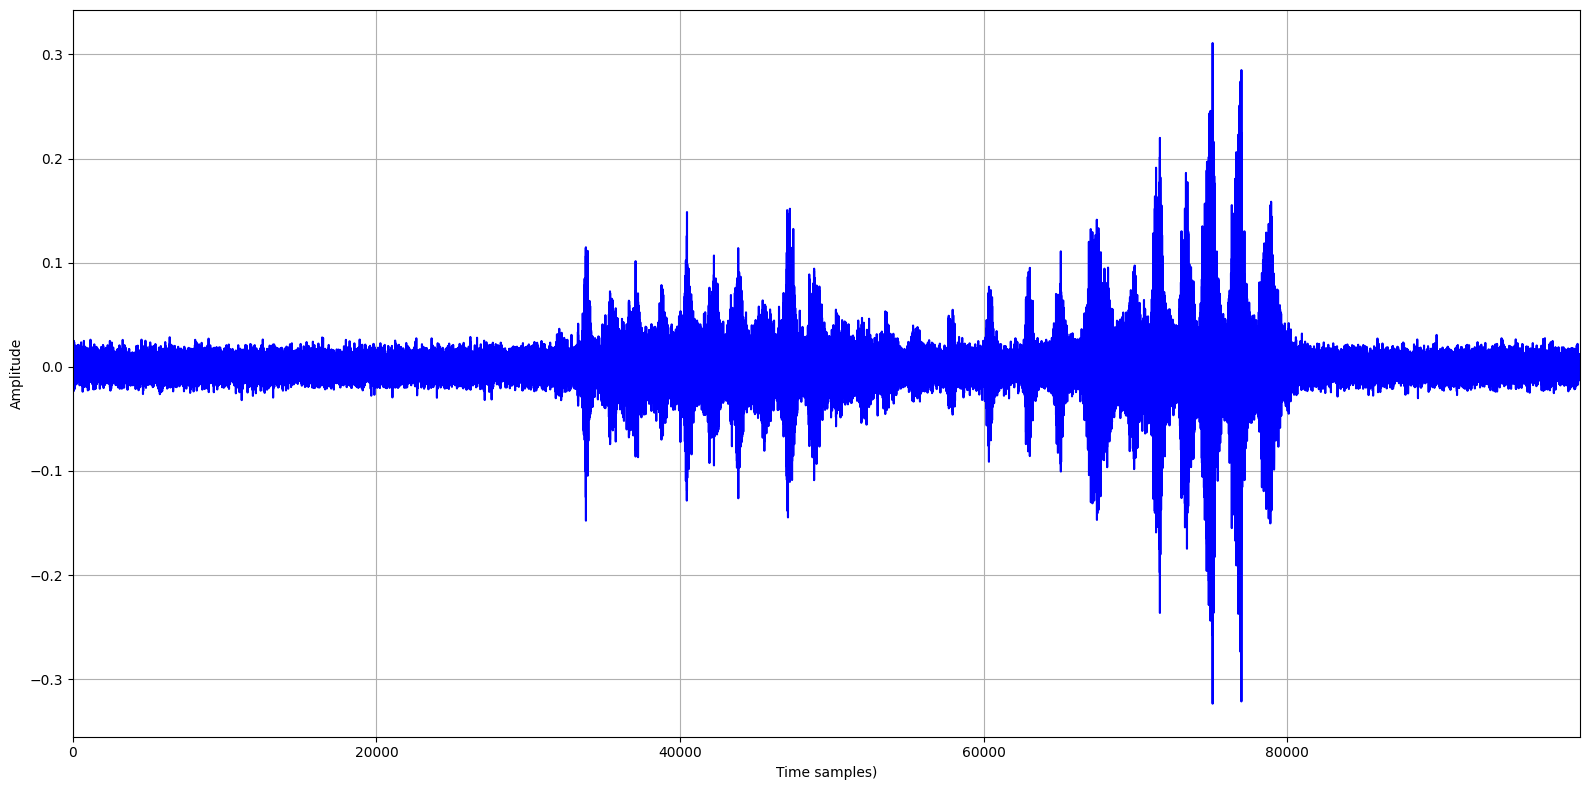

In [25]:
pipeline = MyPipeline(target_sr=32000)

augmented = pipeline(audio, 32000)
plot_waveform(augmented, 20000)